In [1]:
import sys

sys.path.insert(1, 'C:/Users/peter/Desktop/volatility-forecasting/midas')

import numpy as np
import pandas as pd
from scipy.optimize import minimize
from stats import loglikelihood_normal, loglikelihood_student_t
from weights import Beta
from helper_functions import create_matrix
from datetime import datetime, timedelta
from monthdelta import monthdelta
from statsmodels.tools.numdiff import approx_fprime, approx_hess_cs
import time
import scipy.stats as stats
from volatility import Panel_GARCH
import matplotlib.pyplot as plt

In C:\Users\peter\anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\peter\anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\peter\anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In C:\Users\peter\anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\peter\anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mpl

In [2]:
class Panel_GARCH_CSA():
    def __init__(self, plot = True, dist = 'normal', *args):
        self.plot = plot
        self.dist = dist
        self.args = args
    
    def initialize_params(self):
        if self.dist == 'normal':
            self.init_params = np.array([0.9, 0.1, 0.7])
        elif self.dist == 'student-t':
            self.init_params = np.array([0.9, 0.1, 0.7, 4.0])
        else:
            raise ValueError("ValueError exception thrown")
        return self.init_params
    
    def variables(self):
        return ['rho', 'alpha', 'beta']
    
    def model_filter(self, params, X):
        c = np.zeros(X.shape[0])
        sigma2 = np.zeros_like(X)
        
        phi, alpha, beta = params[0], params[1], params[2]
        
        uncond_var = np.nanmean(X ** 2, axis = 0)
        nans = X.isna().sum().values
        X = X.values
        
        for i in range(sigma2.shape[0]):
            if i == 0:
                c[i] = 1
            else:
                c[i] = (1 - phi) + phi * np.nanstd(X[i-1] / (np.sqrt(sigma2[i-1]) * c[i - 1]), ddof = 1)
            for j in range(sigma2.shape[1]):
                if nans[j] == i:
                    sigma2[i][j] = uncond_var[j]
                elif nans[j] < i:
                    sigma2[i][j] = uncond_var[j] * (1 - alpha - beta) + alpha * ((X[i - 1][j] / (np.sqrt(sigma2[i-1][j])*c[i-1])) ** 2) + beta * sigma2[i - 1][j]
                else:
                    pass
        return sigma2, c
    
    def loglikelihood(self, params, X):
        sigma2, _ = self.model_filter(params, X)
        if self.dist == 'normal':
            lls = loglikelihood_normal(X, sigma2).sum()
        elif self.dist == 'student-t':
            lls = loglikelihood_student_t(X, sigma2, params[3]).sum()
        return lls
    
    def simulate(self, params = [0.1, 0.2, 0.6], num = 100, length = 500):
        c = np.zeros(length)
        sigma2 = np.zeros((length, num))
        ret = np.zeros((length, num))
        
        phi, alpha, beta = params[0], params[1], params[2]
        
        for t in range(length):
            if t == 0:
                c[t] = 1.0
                sigma2[t] = 1.0
            else:
                c[t] = (1 - phi) + phi * np.nanstd(ret[t - 1] / (np.sqrt(sigma2[t - 1]) * c[t - 1]), ddof = 1)
                mu = np.mean(ret[ : t] ** 2, axis = 0)
                sigma2[t] = mu * (1 - alpha - beta) + alpha * (ret[t - 1] / (np.sqrt(sigma2[t - 1]) * c[t - 1])) ** 2 + beta * sigma2[t - 1]
            
            ret[t] = stats.norm.rvs(loc = 0.0, scale = np.sqrt(sigma2[t]))
                
        return ret, sigma2, c
    
    def fit(self, y):
        res = minimize(self.loglikelihood,
                       self.initialize_params(),
                       args = (y),
                       method = 'SLSQP',
                       bounds = ((0.0, 1.0), (0.0, 1.0), (0.0, 1.0)),
                       constraints = [{'type': 'ineq', 'fun': lambda x:  1 - x[1] - x[2]}],
                       options = {'disp': False, 'maxiter': 50})
        self.opt = res
        self.optimized_params = self.opt.x
        try:
            hess = approx_hess_cs(self.optimized_params, self.loglikelihood, kwargs = {'y' : y})
            hess /= y.shape[0]
            inv_hess = np.linalg.inv(hess)
            scores = approx_fprime(self.optimized_params, self.loglikelihood, kwargs = {'y' : y})
            score_cov = np.cov(scores.T)
            self.cov_mat = inv_hess.dot(score_cov).dot(inv_hess) / y.shape[0]
            self.standard_errors = np.sqrt(np.diag(self.cov_mat))
        except:
            self.standard_errors = np.linspace(0, 0, len(self.optimized_params))
        if self.variables() == None:
            self.table = pd.DataFrame(data = {'Parameters': self.optimized_params,
                                             'Standard Error': self.standard_errors,
                                             '95% CI Lower': self.optimized_params - stats.norm.ppf(0.975)* self.standard_errors,
                                             '95% CI Higher': self.optimized_params + stats.norm.ppf(0.975)* self.standard_errors})
        else:
            self.table = pd.DataFrame(data = {'Parameters': self.optimized_params,
                                             'Standard Error': self.standard_errors,
                                             '95% CI Lower': self.optimized_params - stats.norm.ppf(0.975)* self.standard_errors,
                                             '95% CI Higher': self.optimized_params + stats.norm.ppf(0.975)* self.standard_errors}, 
                                      index = self.variables())
        if self.plot == True:
            print('Loglikelihood: ', self.opt.fun, '\n')
            print(self.table)
        return
    
    def forecast(self, params, X, H = 1):
        X_new = X
        X_new.loc[X.shape[0]] = 0
        
        sigma2, _ = self.model_filter(params, X_new)
        sigma2 = sigma2 * np.sqrt(H)
        return sigma2[-1]

In [3]:
mod1 = Panel_GARCH()

In [4]:
mod2 = Panel_GARCH_CSA()

In [32]:
ret, sigma, c = mod2.simulate([0.99, 0.05, 0.85], num = 100, length = 500)

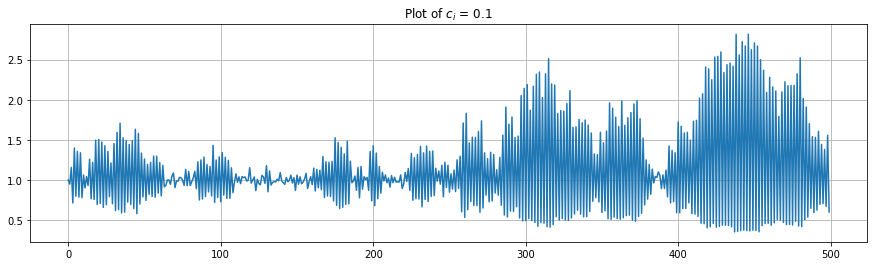

In [33]:
plt.figure(figsize = (15,4))
plt.plot(c)
plt.title('Plot of $c_i$ = 0.1')
plt.grid(True)
plt.show()

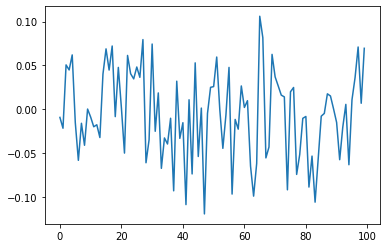

In [38]:
plt.plot(np.mean(ret, axis = 0))

In [9]:
mod2.fit(pd.DataFrame(ret))

Loglikelihood:  141.0352780867816 

       Parameters  Standard Error  95% CI Lower  95% CI Higher
rho      0.900889             0.0      0.900889       0.900889
alpha    0.050520             0.0      0.050520       0.050520
beta     0.799205             0.0      0.799205       0.799205


In [10]:
_, c_sim = mod2.model_filter(mod2.optimized_params, pd.DataFrame(ret))

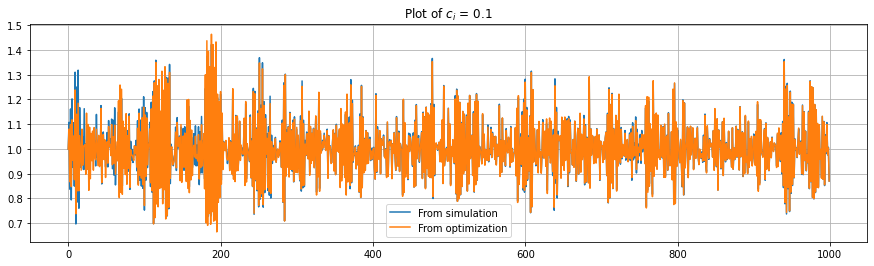

In [11]:
plt.figure(figsize = (15,4))
plt.plot(c, label = "From simulation")
plt.plot(c_sim, label = 'From optimization')
plt.title('Plot of $c_i$ = 0.1')
plt.legend(loc = 'best')
plt.grid(True)
plt.show()

# Let's simulate Panel GARCH with cross sectional adjustment with $\phi$ = 0.0, <br>$\alpha$ = 0.05 and $\beta$ = 0.85

In [62]:
ret, sigma, c = mod2.simulate([0.0, 0.05, 0.85], num = 100, length = 1000)

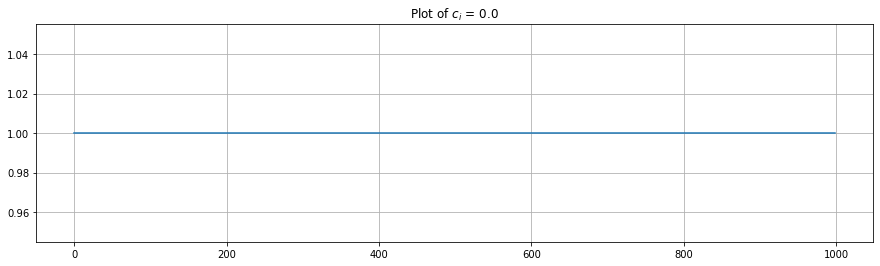

In [63]:
plt.figure(figsize = (15,4))
plt.plot(c)
plt.title('Plot of $c_i$ = 0.0')
plt.grid(True)
plt.show()

In [65]:
mod2.fit(pd.DataFrame(ret))

Loglikelihood:  140.67337677061937 

       Parameters  Standard Error  95% CI Lower  95% CI Higher
rho      0.000000             0.0      0.000000       0.000000
alpha    0.050047             0.0      0.050047       0.050047
beta     0.800450             0.0      0.800450       0.800450


In [16]:
mod1.fit(['01', '01'], pd.DataFrame(ret))

Loglikelihood:  139.46449048530127 

   Parameters  Standard Error  95% CI Lower  95% CI Higher
0    0.055270        0.013255      0.029290       0.081249
1    0.795851        0.016435      0.763639       0.828062


In [4]:
ret_matrix = pd.read_csv('C:/Users/peter/Desktop/volatility-forecasting/results/ret_matrix.csv')
ret_matrix.set_index(pd.to_datetime(ret_matrix.Date), inplace = True)
ret_matrix = ret_matrix.iloc[:, 1:] * 100

ret_mat = ret_matrix.iloc[1:, :]
nan_cols = np.where(ret_mat.isna().sum().values == 1)[0]
nan_index = np.where(ret_mat.iloc[:, nan_cols].isna() == True)[0]
print(set(nan_index))

if len(set(nan_index)) == 1.0:
    ret_mat = ret_mat.drop([ret_mat.index[nan_index[0]]])
    
ret_mat.pop('AMCR')

{455}


Date
1999-11-19         NaN
1999-11-22         NaN
1999-11-23         NaN
1999-11-24         NaN
1999-11-26         NaN
                ...   
2020-10-26   -3.148416
2020-10-27   -0.566043
2020-10-28   -2.393602
2020-10-29    1.729151
2020-10-30   -0.668895
Name: AMCR, Length: 5270, dtype: float64

In [5]:
ret_mat_nullnan = ret_mat.iloc[:, np.where(ret_mat.isna().sum().values == 0)[0]]

In [6]:
y = ret_mat[(ret_mat.index >= datetime(1999,12,1) + monthdelta(60)) & (ret_mat.index < datetime(2005,1,1) + monthdelta(60))]
y_nullnan = ret_mat_nullnan[(ret_mat_nullnan.index >= datetime(1999,12,1) + monthdelta(60)) & (ret_mat_nullnan.index < datetime(2005,1,1) + monthdelta(60))]

In [7]:
model = Panel_GARCH_CSA()
print('---- Teljes Panelra: ----')
start = time.time()
model.fit(y)

---- Teljes Panelra: ----


<ipython-input-3-aa1805160afb>:25: RuntimeWarning: Mean of empty slice
  uncond_var = np.nanmean(X ** 2, axis = 0)
C:/Users/peter/Desktop/volatility-forecasting/midas\stats.py:35: RuntimeWarning: divide by zero encountered in log
  lls = -0.5 * (np.log(2*np.pi) + np.log(sigma2) + resid ** 2 / sigma2)
<ipython-input-3-aa1805160afb>:33: RuntimeWarning: divide by zero encountered in true_divide
  c[i] = (1 - phi) + phi * np.nanstd(X[i-1] / (np.sqrt(sigma2[i-1]) * c[i - 1]), ddof = 1)
C:\Users\peter\anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1545: RuntimeWarning: invalid value encountered in subtract
  np.subtract(arr, avg, out=arr, casting='unsafe')
<ipython-input-3-aa1805160afb>:38: RuntimeWarning: divide by zero encountered in double_scalars
  sigma2[i][j] = uncond_var[j] * (1 - alpha - beta) + alpha * ((X[i - 1][j] / (np.sqrt(sigma2[i-1][j])*c[i-1])) ** 2) + beta * sigma2[i - 1][j]
<ipython-input-3-aa1805160afb>:33: RuntimeWarning: invalid value encountered in sqrt
  c[i] = 

Loglikelihood:  969.6554292131473 

       Parameters  Standard Error  95% CI Lower  95% CI Higher
rho      0.980362             0.0      0.980362       0.980362
alpha    0.133889             0.0      0.133889       0.133889
beta     0.774680             0.0      0.774680       0.774680


In [8]:
_, c_data = model.model_filter(model.optimized_params, y)

<ipython-input-3-aa1805160afb>:25: RuntimeWarning: Mean of empty slice
  uncond_var = np.nanmean(X ** 2, axis = 0)


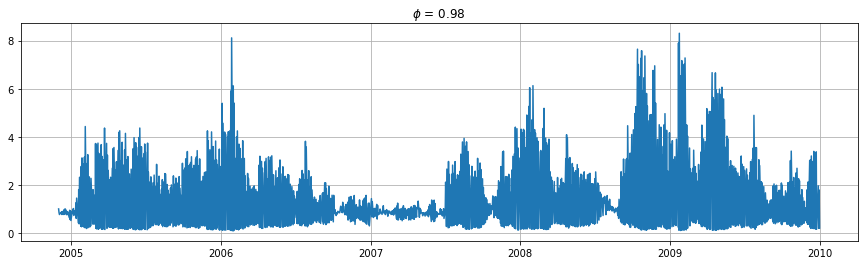

In [10]:
plt.figure(figsize = (15,4))
plt.plot(y.index, c_data)
plt.title(f'$\phi$ = {round(model.optimized_params[0],3)}')
plt.grid(True)
plt.show()

In [4]:
df = pd.read_csv('C:/Users/peter/Desktop/volatility-forecasting/results/pgarch_csa/params_est.csv')
df.set_index(pd.to_datetime(df.iloc[:, 0]), inplace = True)
df = df.iloc[:, 1:]

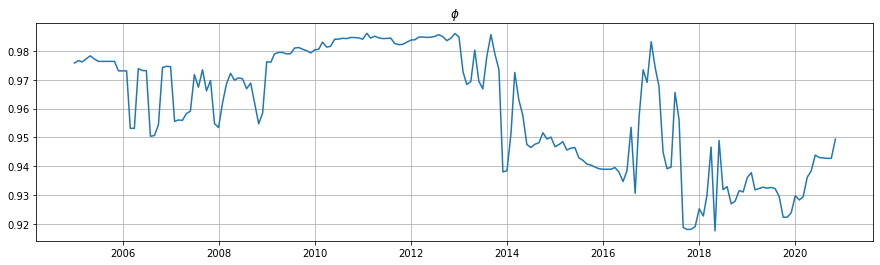

In [5]:
plt.figure(figsize = (15,4))
plt.plot(df.index, df.rho)
plt.title(r'$\phi$')
plt.grid(True)
plt.show()

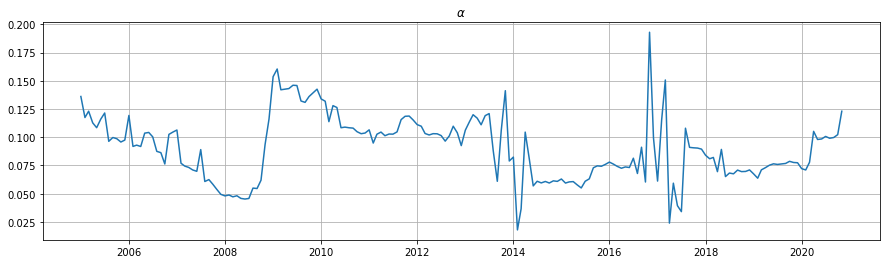

In [6]:
plt.figure(figsize = (15,4))
plt.plot(df.index, df.alpha)
plt.title(r'$\alpha$')
plt.grid(True)
plt.show()

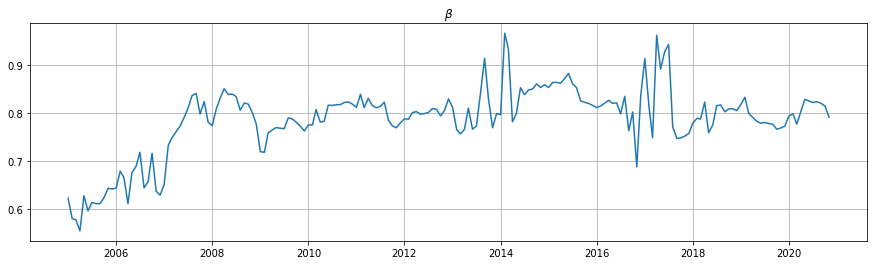

In [7]:
plt.figure(figsize = (15,4))
plt.plot(df.index, df.beta)
plt.title(r'$\beta$')
plt.grid(True)
plt.show()

In [8]:
import seaborn as sns

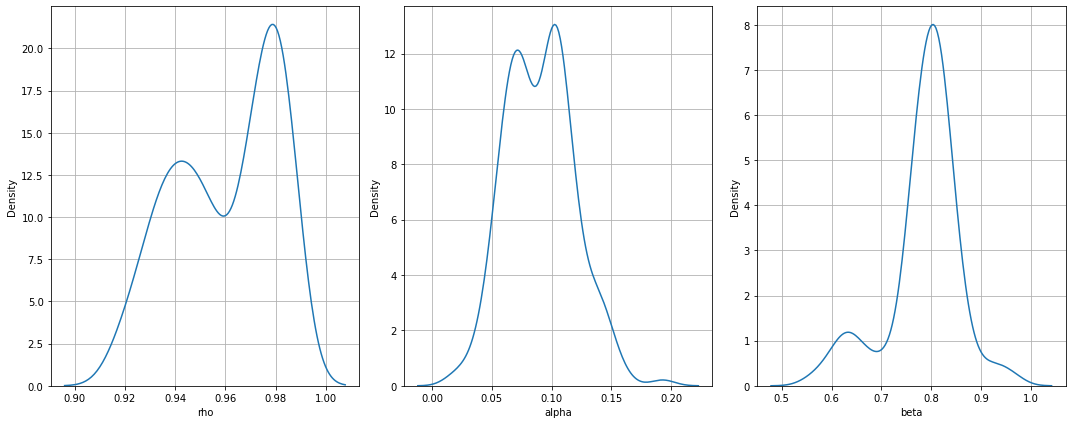

In [9]:
fig, ax = plt.subplots(1, 3, figsize=(15, 6), tight_layout=True)
sns.kdeplot(df.rho, ax = ax[0])
ax[0].grid(True)
sns.kdeplot(df.alpha, ax = ax[1])
ax[1].grid(True)
sns.kdeplot(df.beta, ax = ax[2])
ax[2].grid(True)
plt.show()

In [28]:
forecasts = pd.DataFrame()

In [42]:
for dt in df.index:
    end = pd.to_datetime(dt)
    start = end - monthdelta(61)
    y = ret_mat[(ret_mat.index >= start) & (ret_mat.index < end)]
    forc = Panel_GARCH_CSA().forecast(df.loc[dt].values, y)
    forecasts[dt] = forc

In [51]:
forecasts = forecasts.replace(0, np.nan)

In [52]:
forecasts.to_csv('C:/Users/peter/Desktop/volatility-forecasting/results/pgarch_csa/forecasts_all.csv')

In [53]:
ewma = pd.read_csv('C:/Users/peter/Desktop/volatility-forecasting/results/Panel_EWMA/forecast.csv')

In [55]:
ewma.set_index(ewma.iloc[:,0], inplace = True)
ewma = ewma.iloc[:, 1:]

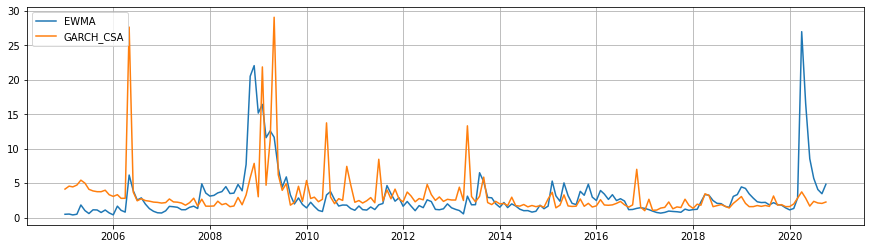

In [64]:
plt.figure(figsize = (15,4))
plt.plot(forecasts.columns[:-1], ewma.loc['MSFT'].values, label = 'EWMA')
plt.plot(forecasts.columns[:-1], forecasts.loc['MSFT'][:-1].values, label = 'GARCH_CSA')
plt.legend(loc = 'best')
plt.grid(True)
plt.show()